<a href="https://colab.research.google.com/github/nagalakshmi-nimmagadda/MNIST-CNN-COLAB/blob/main/MNIST_Model1_Development.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# MNIST Classification - Model 1: Basic Implementation

In [ ]:
# Install required packages
!pip install torch torchvision tqdm matplotlib torchsummary

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# Set plot style
plt.style.use('default')

# Set random seed for reproducibility
SEED = 1
torch.manual_seed(SEED)

# Check CUDA availability
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
print("CUDA Available?", cuda)

if cuda:
    torch.cuda.manual_seed(SEED)


CUDA Available? True


In [ ]:
# Define the model
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, 3)  # 28x28x1 -> 26x26x4
        self.conv2 = nn.Conv2d(4, 8, 3)  # 26x26x4 -> 24x24x8
        self.pool1 = nn.MaxPool2d(2, 2)  # 24x24x8 -> 12x12x8
        self.conv3 = nn.Conv2d(8, 16, 3)  # 12x12x8 -> 10x10x16
        self.conv4 = nn.Conv2d(16, 10, 1)  # 10x10x16 -> 10x10x10
        self.gap = nn.AdaptiveAvgPool2d(1)  # 10x10x10 -> 1x1x10

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = self.conv4(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=1)

In [ ]:
# Model Parameter Summary using torchsummary
from torchsummary import summary

# Initialize model
model = BasicCNN().to(device)

# Print detailed model summary
print("\nDetailed Model Summary:")
print("=====================")
summary(model, input_size=(1, 28, 28))  # MNIST images are 1x28x28

# Print total parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal Parameters: {total_params:,}")


Detailed Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 26, 26]              40
            Conv2d-2            [-1, 8, 24, 24]             296
         MaxPool2d-3            [-1, 8, 12, 12]               0
            Conv2d-4           [-1, 16, 10, 10]           1,168
            Conv2d-5           [-1, 10, 10, 10]             170
 AdaptiveAvgPool2d-6             [-1, 10, 1, 1]               0
Total params: 1,674
Trainable params: 1,674
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.01
Estimated Total Size (MB): 0.09
----------------------------------------------------------------

Total Parameters: 1,674


In [ ]:
# Data Loading and Preprocessing
def load_data():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('data', train=False, transform=transform)

    # Dataloader arguments
    dataloader_args = dict(
        shuffle=True,
        batch_size=128,
        num_workers=4,
        pin_memory=True
    ) if cuda else dict(
        shuffle=True,
        batch_size=64
    )

    # Create dataloaders
    train_loader = torch.utils.data.DataLoader(train_dataset, **dataloader_args)
    test_loader = torch.utils.data.DataLoader(test_dataset, **dataloader_args)

    return train_loader, test_loader

# Load data with proper configuration
train_loader, test_loader = load_data()

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 12.6MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 444kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.09MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 10.9MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# Training Metrics Class
class TrainingMetrics:
    def __init__(self):
        self.train_losses = []
        self.test_losses = []
        self.train_acc = []
        self.test_acc = []
        self.best_test_acc = 0
        self.epoch_times = []

    def update(self, train_loss, test_loss, train_accuracy, test_accuracy):
        self.train_losses.append(train_loss)
        self.test_losses.append(test_loss)
        self.train_acc.append(train_accuracy)
        self.test_acc.append(test_accuracy)
        self.best_test_acc = max(self.best_test_acc, test_accuracy)

In [ ]:
# Training Function
def train_epoch(model, train_loader, optimizer, device):
    model.train()
    pbar = tqdm(train_loader, desc='Training')
    train_loss = 0
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # Predict
        output = model(data)

        # Calculate loss
        loss = F.nll_loss(output, target)
        train_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update Progress Bar
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Accuracy': f'{100. * correct/processed:.2f}%'
        })

    return train_loss/len(train_loader), 100. * correct/processed

In [ ]:
# Testing Function
def test(model, test_loader, device):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    print(f'\nTest set: Average loss: {test_loss:.4f}, '
          f'Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')

    return test_loss, accuracy

In [ ]:
# Training Configuration
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
metrics = TrainingMetrics()
epochs = 15

# Training Loop
for epoch in range(1, epochs + 1):
    print(f'\nEpoch {epoch}')
    print('=' * 40)

    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device)
    test_loss, test_acc = test(model, test_loader, device)

    metrics.update(train_loss, test_loss, train_acc, test_acc)

    # Print epoch summary
    print(f'Training - Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%')
    print(f'Testing  - Loss: {test_loss:.4f}, Accuracy: {test_acc:.2f}%')


Epoch 1


Training:   0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.1399, Accuracy: 2605/10000 (26.05%)

Training - Loss: 2.2695, Accuracy: 15.35%
Testing  - Loss: 2.1399, Accuracy: 26.05%

Epoch 2


Training:   0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5335, Accuracy: 8445/10000 (84.45%)

Training - Loss: 1.1887, Accuracy: 60.49%
Testing  - Loss: 0.5335, Accuracy: 84.45%

Epoch 3


Training:   0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3058, Accuracy: 9114/10000 (91.14%)

Training - Loss: 0.4696, Accuracy: 86.03%
Testing  - Loss: 0.3058, Accuracy: 91.14%

Epoch 4


Training:   0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2746, Accuracy: 9232/10000 (92.32%)

Training - Loss: 0.3390, Accuracy: 90.01%
Testing  - Loss: 0.2746, Accuracy: 92.32%

Epoch 5


Training:   0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2692, Accuracy: 9201/10000 (92.01%)

Training - Loss: 0.2868, Accuracy: 91.50%
Testing  - Loss: 0.2692, Accuracy: 92.01%

Epoch 6


Training:   0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2239, Accuracy: 9359/10000 (93.59%)

Training - Loss: 0.2472, Accuracy: 92.53%
Testing  - Loss: 0.2239, Accuracy: 93.59%

Epoch 7


Training:   0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1732, Accuracy: 9482/10000 (94.82%)

Training - Loss: 0.2285, Accuracy: 93.20%
Testing  - Loss: 0.1732, Accuracy: 94.82%

Epoch 8


Training:   0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1740, Accuracy: 9474/10000 (94.74%)

Training - Loss: 0.1981, Accuracy: 93.96%
Testing  - Loss: 0.1740, Accuracy: 94.74%

Epoch 9


Training:   0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1792, Accuracy: 9474/10000 (94.74%)

Training - Loss: 0.1879, Accuracy: 94.41%
Testing  - Loss: 0.1792, Accuracy: 94.74%

Epoch 10


Training:   0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1541, Accuracy: 9528/10000 (95.28%)

Training - Loss: 0.1756, Accuracy: 94.73%
Testing  - Loss: 0.1541, Accuracy: 95.28%

Epoch 11


Training:   0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1782, Accuracy: 9459/10000 (94.59%)

Training - Loss: 0.1640, Accuracy: 95.09%
Testing  - Loss: 0.1782, Accuracy: 94.59%

Epoch 12


Training:   0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1428, Accuracy: 9577/10000 (95.77%)

Training - Loss: 0.1578, Accuracy: 95.23%
Testing  - Loss: 0.1428, Accuracy: 95.77%

Epoch 13


Training:   0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1182, Accuracy: 9658/10000 (96.58%)

Training - Loss: 0.1460, Accuracy: 95.57%
Testing  - Loss: 0.1182, Accuracy: 96.58%

Epoch 14


Training:   0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1693, Accuracy: 9503/10000 (95.03%)

Training - Loss: 0.1464, Accuracy: 95.55%
Testing  - Loss: 0.1693, Accuracy: 95.03%

Epoch 15


Training:   0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1139, Accuracy: 9640/10000 (96.40%)

Training - Loss: 0.1343, Accuracy: 95.94%
Testing  - Loss: 0.1139, Accuracy: 96.40%


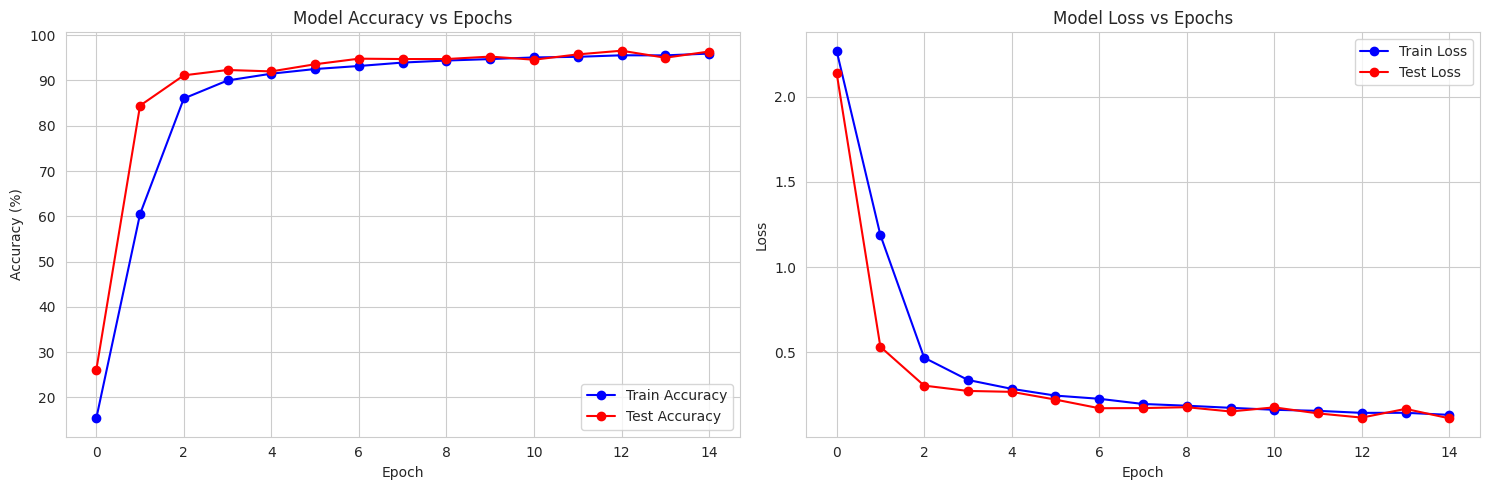


Best Results (Epoch 13)
Train Accuracy: 95.94%
Test Accuracy:  96.58%
Train Loss:     0.1343
Test Loss:      0.1139


In [ ]:
# Visualization Function
def plot_training_metrics(metrics):
    plt.figure(figsize=(15, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(metrics.train_acc, 'b-', label='Train Accuracy', marker='o')
    plt.plot(metrics.test_acc, 'r-', label='Test Accuracy', marker='o')
    plt.title('Model Accuracy vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(metrics.train_losses, 'b-', label='Train Loss', marker='o')
    plt.plot(metrics.test_losses, 'r-', label='Test Loss', marker='o')
    plt.title('Model Loss vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print best results
    best_epoch = metrics.test_acc.index(max(metrics.test_acc)) + 1
    print("\nBest Results (Epoch {})".format(best_epoch))
    print("=" * 40)
    print(f"Train Accuracy: {max(metrics.train_acc):.2f}%")
    print(f"Test Accuracy:  {max(metrics.test_acc):.2f}%")
    print(f"Train Loss:     {min(metrics.train_losses):.4f}")
    print(f"Test Loss:      {min(metrics.test_losses):.4f}")

# Plot results
plot_training_metrics(metrics)


In [ ]:
# Final Results Summary
print("\nFinal Results Summary")
print("=" * 40)
print(f"Best Test Accuracy: {metrics.best_test_acc:.2f}%")
print(f"Final Train Accuracy: {metrics.train_acc[-1]:.2f}%")
print(f"Final Test Accuracy: {metrics.test_acc[-1]:.2f}%")
print(f"Total Parameters: {sum(p.numel() for p in model.parameters()):,}")

# Save model (optional)
torch.save(model.state_dict(), 'model1.pth')


Final Results Summary
Best Test Accuracy: 96.58%
Final Train Accuracy: 95.94%
Final Test Accuracy: 96.40%
Total Parameters: 1,674


# Model 1 Analysis

## Target
- Establish baseline performance with minimal architecture
- Keep parameters under 8000
- Achieve good accuracy without advanced techniques

## Results
1. Model Performance:
   - Best Train Accuracy: 95.94% (Epoch 15)
   - Best Test Accuracy: 96.58% (Epoch 13)
   - Final Train Loss: 0.1343
   - Final Test Loss: 0.1139
   - Training Time: ~16-17 seconds per epoch

2. Training Progression:
   - Initial phase (Epochs 1-3):
     * Rapid improvement from 26.05% to 91.14% test accuracy
     * Sharp decrease in loss from 2.1399 to 0.3058
   
   - Middle phase (Epochs 4-9):
     * Steady improvement from 92.32% to 94.74%
     * Gradual loss reduction from 0.2746 to 0.1792
   
   - Final phase (Epochs 10-15):
     * Consistent performance above 95%
     * Best performance at Epoch 13 (96.58%)
     * Slight fluctuations in last epochs

3. Model Behavior:
   - Learning Rate Impact:
     * Fast initial learning (26.05% → 84.45% in first two epochs)
     * Good convergence rate
   
   - Stability:
     * Minimal overfitting (train-test gap < 1%)
     * Consistent performance in later epochs
     * No significant performance degradation

## Analysis
1. Strengths:
   - Achieved high accuracy (96.58%) with simple architecture
   - Good generalization (small gap between train and test accuracy)
   - Stable training progression
   - Fast convergence (reached 91% by epoch 3)

2. Areas for Improvement:
   - Slight performance fluctuations in later epochs
   - Could potentially benefit from learning rate scheduling
   - Might improve with regularization techniques